# Application 1.14: Using cross-correlation for synchronization of two signals or time-alignment.

Assume a discrete-time sinal $x[n]$ is transmitted through a communication channel and the receiver obtains a delayed and distorted version $y[n]$. The task is to estimate the delay imposed by the channel. The transmitter does not ``stamp'' the time when the transmission starts, but uses a predefined preamble sequence $p[n]$ that is known by the receiver. The receiver will then guess the beginning of the transmitted message by searching for the preamble sequence in $y[n]$ via cross-correlation. Before trying an example that pretends to be realistic, some simple manipulations can clarify the procedure.

Assume we want to align the signal $x[n]=\delta[n]+2\delta[n-1]+3\delta[n-2]$ with $y[n]=3\delta[n]+2\delta[n-1]+\delta[n-2]+\delta[n-3]+2\delta[n-4]+2\delta[n-5]$. Intuitively, the signal $x[n-3]$ is a good match to $y[n]$. Alternatively, $y[n+3]$ matches $x[n]$. The {\matlab} command \ci{xcorr(x,y)} for cross-correlation can help finding the best lag $L$ such that $x[n+L]$ matches $y[n]$. The procedure is illustrated below:

In [56]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.random import rand, randn
import scipy.signal as sp

In [57]:
# Mimic matlab's xcorr
def xcorr(x,y):
    return sp.correlate(x,y,'full'), sp.correlation_lags(len(x),len(y),'full')

Correlation peak: 14
Estimated delay (in samples): -3


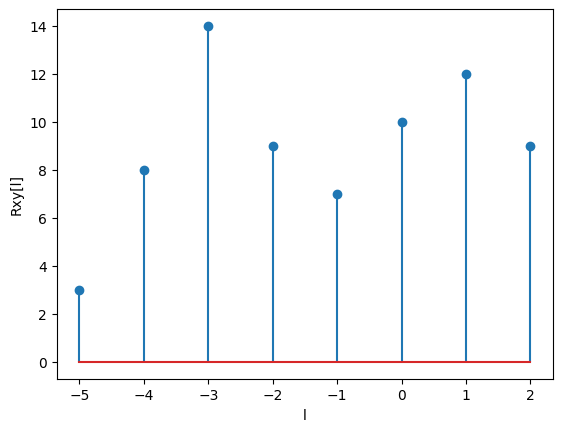

In [58]:
x = np.arange(1,4) # Some signal
y = np.concatenate((np.arange(3,0,-1),x)) # The other signal

c, lags = xcorr(x,y) # Find cross-correlation
plt.stem(lags,c) # Plot
plt.xlabel("l")
plt.ylabel("Rxy[l]")

L = lags[np.argmax(c)] # Lag for max cross-correlation
print("Correlation peak:",np.max(c)) # Show the maximum cross-correlation value
print("Estimated delay (in samples):",L)

The result is $L=-3$. If the order is swapped to xcorr(y,x) as below, the result is $L=3$.


In [59]:
c, lags = xcorr(y,x)
print("Correlation peak:",np.max(c)) # Show the maximum cross-correlation value
print("Estimated delay (in samples):", lags[np.argmax(c)]) # Max cross-correlation y,x lag

Correlation peak: 14
Estimated delay (in samples): 3


It should be noticed that the cross-correlation is far from perfect with respect to capturing similarity between waveforms. For example, if $y[n]$ is changed to y=[(4:-1:1) x], the previous commands would indicate the best lag as $L=1$. The reader is invited to play with simple signals and find more evidence of this limitation.
As a rule of thumb, the cross-correlation will work well if one of the signals is a delayed version of the other, without significant distortion. However, in situations such as reverberant rooms where one of the signals is composed by a sum of multi-path (with distinct delays) versions of the other signal, more sophisticated techniques should be used.


Another aspect is that, in some applications, the best similarity measure is the absolute value of the cross-correlation (i.e., L = np.argmax(np.abs(c)) instead of L = np.argmax(c)). For example, this is the case when $x[n]$ can be compared either to $y[n]$ or $-y[n]$.


The following code, from snip_signals_time_delay.m illustrates the delay estimation between two signals x[n] and y[n]. The
vector y, representing y[n], is obtained by delaying x and adding Gaussian noise to have
a given SNR.

The added delay was: 0.25
The estimated delay was: -0.25


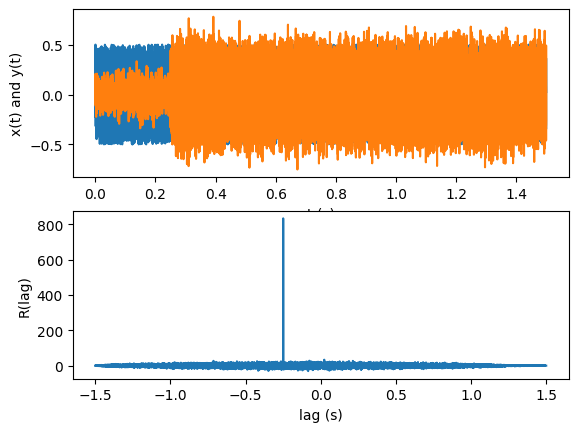

In [60]:
Fs = 8000 # Sampling frequency
Ts = 1/Fs # Sampling interval
N = int(1.5*Fs) # 1.5 seconds
t = np.arange(N)*Ts

if True:
    x = rand(N) - 0.5 # Zero mean uniformly distributed
else:
    x = cos(2*pi*100*t) # Cosine

delay_in_samples = 2000
time_delay = delay_in_samples*Ts # Delay in seconds

y = np.concatenate((np.zeros(delay_in_samples),x[:- delay_in_samples]))

SNRdb = 10 # Specified SNR
signal_power = np.mean((x**2))
noise_power = signal_power/(10**(SNRdb/10))
noise = np.sqrt(noise_power)*randn(len(y))
y = y+noise

plt.subplot(211)
plt.plot(t,x)
plt.plot(t,y)
plt.xlabel("t (s)")
plt.ylabel("x(t) and y(t)")

c, lags = xcorr(x,y) # Find crosscorrelation
plt.subplot(212)
plt.plot(lags*Ts,c)
plt.xlabel("lag (s)")
plt.ylabel("R(lag)")
L = lags[np.argmax(np.abs(c))] # Find the lag for maximum absolute crosscorrelation
estimated_time_delay = L*Ts
print("The added delay was:",time_delay)
print("The estimated delay was:", estimated_time_delay)

As the figures show. The estimated delay via xcorr(x,y)
was -0.25 s. The negative value indicates that x is advanced with respect to y. The
command xcorr(y,x) would lead to a positive delay of 0.25 s.

After running the code as it is, observe what happens if x=rand(1,N), i.\,e., use a signal with a mean different than zero (0.5, in this case). In this case, the correlation is affected in a way that the peak indicating the delay is less pronounced. Another test is to use a cosine (modify the if) with delayInSamples assuming a small value with respect to the total length N of the vectors. The estimation can fail, indicating the delay to be zero. Another parameter to play with is the SNR. Use values smaller than 10 dB to visualize how the correlation can be useful even with negative SNR.


It is important to address another issue: comparing vectors of different length. Assume two signals $x[n]$ and  $y[n]$ should be aligned in time and then compared sample-by-sample, for example to calculate the error $x[n]-y[n]$. There is a small problem if the vectors have a different length.
Assuming that xcorr(x,y) indicated the best lag is positive ($L>0$), an useful post-processing for comparing $x[n]$ and $y[n]$ is to delete samples of $x[n]$. If $L$ is negative, the first samples of $y[n]$ can be deleted. snip_signals_time_aligment illustrates the operation and makes sure that the vectors representing the signals have the same length.


[  3   1  -2  -2   1  -4  -3  -5 -10]


Text(0.5, 1.0, 'Error Between Aligned x and y')

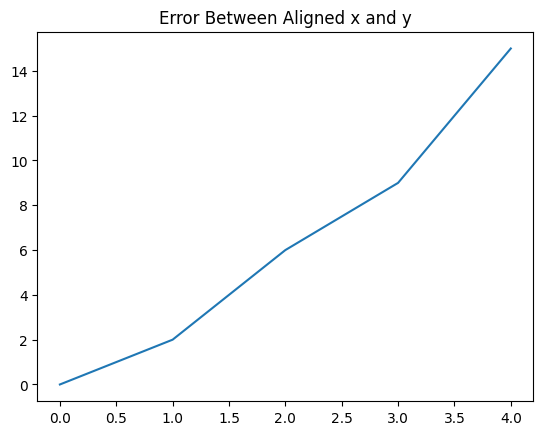

In [72]:
x = np.array([1, -2, 3, 4, 5, -1]) # Some signal
y = np.array([3, 1, -2, -2, 1, -4, -3, -5, -10]) # The other signal
c, lags = xcorr(x,y) # Find crosscorrelation
L = lags[np.argmax(np.abs(c))] # Lag for the maximum
print(y)
if L > 0:
    x = x[L:] # Delete frist L samples from x
else:
    y = y[-L:] # Delete first L samples from y

if len(x) > len(y): # Make sure lengths are the same
    x = x [:len(y)]
else:
    y = y [:len(x)] 
plt.figure("time_alignment")
plt.plot (x-y)
plt.title ( "Error Between Aligned x and y")

Elaborate and execute the following experiment: record two utterances of the same word, storing the first in a vector x and the second in y. Align the two signals via cross-correlation and calculate the mean-squared error (MSE) between them (for the MSE calculation it may be necessary to have vectors of the same length, as discussed).
